In [2]:
import numpy
import os
import cv2
import time
import matplotlib.pyplot
from PIL import Image
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [3]:
width = 160
height = 60
TRAIN_DATA = 'lane_data'
VAL_DATA = 'lane_data/val'

Xtrain =[]
Ytrain = []
# one-host encoding
dict = {'right': [1, 0], 'wrong': [0, 1]}

In [4]:
def rotate_image(image, label):
    list_image = []
    list_label = []
    count = 0
    center = (width // 2, height // 2)
    for distance in range (-8, 10, 2):
        translated_image = cv2.warpAffine(image, numpy.float32([[1, 0, distance], [0, 1, 0]]) , (width, height))
        for degrees in range(-15, 20, 5):
            distance_rotated_image = cv2.warpAffine(translated_image, cv2.getRotationMatrix2D(center, degrees, 1.0), (width, height))
            list_image.append(distance_rotated_image)
            list_label.append(label)
            count = count + 1
    return list_image, list_label

In [5]:
def ReadData(file):
    Data = []
    Label = []
    label = ''
    for folderName in os.listdir(file):
        filename_path = os.path.join(file, folderName)
        list_filename_sub_path = []
        label = folderName
        for filename_sub in os.listdir(filename_path):
            if (".jpg" in filename_sub or ".png" in filename_sub):
                filename_sub_path = os.path.join(filename_path, filename_sub)
                img = numpy.array(Image.open(filename_sub_path))
                img = cv2.resize(img, (width, height))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                list_rotate_image, list_label = rotate_image(img, dict[(label)])
                list_filename_sub_path.extend(list_rotate_image)
                Label.extend(list_label)
        Data.extend(list_filename_sub_path)
    return Data, Label


In [6]:
# Đọc dữ liệu từ TRAIN_DATA
Xtrain, Ytrain = ReadData(TRAIN_DATA)

print(len(Xtrain))
# Chia dữ liệu thành tập huấn luyện và tập validation
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.3, random_state=42)

89838


In [11]:
from tensorflow.keras.losses import CategoricalCrossentropy


model = models.Sequential([
    layers.Conv2D(4, (3, 3), input_shape=(height, width, 1), activation = 'relu'),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.15),
    
    layers.Conv2D(8, (3, 3), activation = 'relu'),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Conv2D(16, (3, 3), activation = 'relu'),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(2000, activation = 'relu'),
    layers.Dense(1000, activation = 'relu'),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(2, activation = 'softmax'),
])

model.summary()
adam = Adam(learning_rate=0.001)
# model.compile(optimizer='SGD',
#                              loss='mse',
#                              metrics=['accuracy'])

# Compile the model with MeanSquaredError loss function
model.compile(optimizer=adam,
              loss=CategoricalCrossentropy(), #MSE
              metrics=['accuracy'])

early_callback = tensorflow.keras.callbacks.EarlyStopping(monitor="loss", min_delta= 0 , patience=10, verbose=1, mode="auto")

# history = model.fit(numpy.array(Xtrain), numpy.array(Ytrain), validation_data = (numpy.array(Xval), numpy.array(Yval)), epochs=300, batch_size=1200,
#                          callbacks = [early_callback],
#                          verbose=True)

from tensorflow.keras.callbacks import CSVLogger

# Định nghĩa callback CSVLogger để lưu loss và accuracy vào file CSV
csv_logger = CSVLogger('training_log.csv', separator=',', append=False)

# Huấn luyện mô hình với callback CSVLogger
history = model.fit(numpy.array(Xtrain), numpy.array(Ytrain),
                    validation_data=(numpy.array(Xval), numpy.array(Yval)),
                    epochs=90, batch_size=1200,
                    callbacks=[early_callback, csv_logger],
                    verbose=True)

model.save('model_trained.h5')

c:\Users\nguye\OneDrive\Desktop\U\kì 6\PBL5\LaneSenseGuard\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 58, 158, 4)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 79, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 29, 79, 4)      │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 29, 79, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 77, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 38, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 38, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 38, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 36, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 18, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 18, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 18, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1440)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2000)           │     2,882,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,435,418 (20.73 MB)

 Trainable params: 5,435,362 (20.73 MB)

 Non-trainable params: 56 (224.00 B)

Epoch 1/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.5745 - loss: 1.0290 - val_accuracy: 0.6398 - val_loss: 0.6212
Epoch 2/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6603 - loss: 0.6034 - val_accuracy: 0.6759 - val_loss: 0.5936
Epoch 3/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6851 - loss: 0.5811 - val_accuracy: 0.6910 - val_loss: 0.5743
Epoch 4/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7156 - loss: 0.5501 - val_accuracy: 0.7110 - val_loss: 0.5518
Epoch 5/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7285 - loss: 0.5317 - val_accuracy: 0.7375 - val_loss: 0.5193
Epoch 6/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7570 - loss: 0.4952 - val_accuracy: 0.7461 - val_loss: 0.5040
Epoch 7/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7680 - loss: 0.4692 - val_accuracy: 0.7570 - val_loss: 0.4863
Epoch 8/90
53/53 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7806 - loss: 0.4510 - val_accuracy: 0.7653 - val_loss:

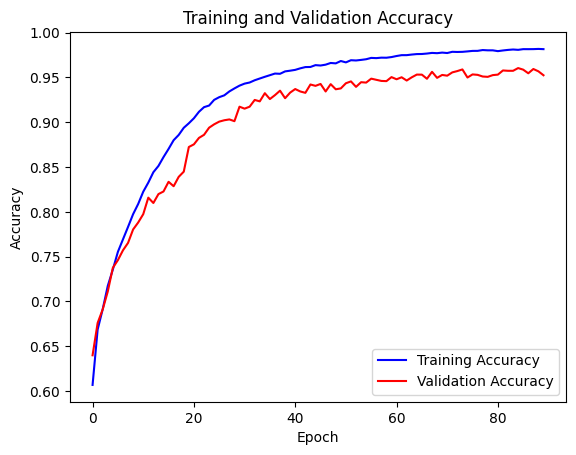

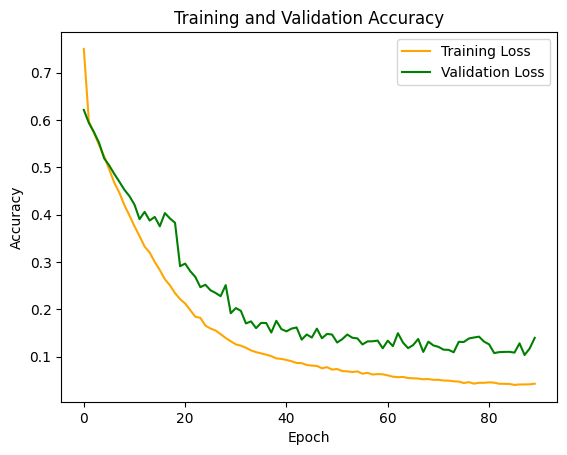

In [6]:

# print(history.history.keys())
# matplotlib.pyplot.plot(history.history['loss'], color='red')
# # matplotlib.pyplot.plot(history.history)
# # matplotlib.pyplot.title('model m')
# matplotlib.pyplot.ylabel('loss')
# matplotlib.pyplot.xlabel('epoch')
# matplotlib.pyplot.show()
# # summarize history for loss mse
# matplotlib.pyplot.plot(history.history['accuracy'], color='blue')
# matplotlib.pyplot.ylabel('accuracy')
# matplotlib.pyplot.xlabel('epoch')
# matplotlib.pyplot.show()

import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
log_data = pd.read_csv('training_log.csv')

# Accuracy
plt.plot(log_data['accuracy'], label='Training Accuracy', color='blue')
plt.plot(log_data['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Loss
plt.plot(log_data['loss'], label='Training Loss', color='orange')
plt.plot(log_data['val_loss'], label='Validation Loss', color='green')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()



In [17]:
dict = {'true': [1, 0], 'false': [0, 1]}
name_result = ['right', 'wrong']

# load model
modelTrained = keras.models.load_model('./model_trained.h5')

# modelTrained.summary()

# dự đoán
# predict = modelTrained.predict(numpy.array(Xval))

img = numpy.array(Image.open('lane_data/wrong/result_b1w20.jpg'))

def result(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    result = name_result[numpy.argmax(modelTrained.predict(image.reshape(-1, height, width, 1)))]
    return result

print(result(img))




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
wrong
